<br>
<h1 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Exploration of Anndata object</h1>
<br>

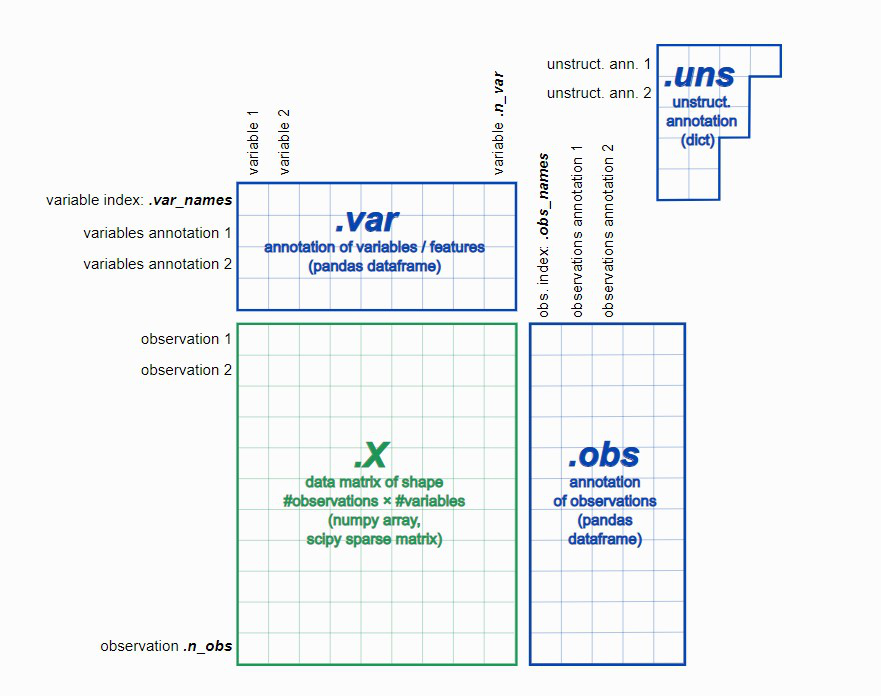

In [3]:
import PIL
from PIL import Image
Image.open("../input/scrnaseq-analysis-model-outputs/Screenshot 2021-09-20 112018.jpg")

<h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Introduction - Anndata</h1>

### Anndata : https://anndata.readthedocs.io/en/latest/
AnnData stores observations (samples) of variables/features in the rows of a matrix. 

Single dimensional annotations of the observation and variables are stored in the obs and var attributes as DataFrames. This is intended for metrics calculated over their axes. Multi-dimensional annotations are stored in obsm and varm, which are aligned to the objects observation and variable dimensions respectively. Square matrices representing graphs are stored in obsp and varp, with both of their own dimensions aligned to their associated axis. Additional measurements across both observations and variables are stored in layers.

- Anndata.X - Data matrix of shape n_obs × n_vars - stores the count matrix
- Anndata.obs - One-dimensional annotation of observations (pd.DataFrame). - stores metadata about the observations (cells)
- var - One-dimensional annotation of variables/ features (pd.DataFrame). - stores metadata about the variables (genes)
- uns - unstructured annotation (ordered dictionary). - stores any additional, unstructured information we decide to attach later

### Installations

In [ ]:
!pip install -q scanpy

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

<h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Exploring a Test Anndata from SCVI</h1>

Immune cells from the murine spleen and lymph nodes [GayosoSteier21] - 
https://docs.scvi-tools.org/en/stable/api/reference/scvi.data.spleen_lymph_cite_seq.html#scvi.data.spleen_lymph_cite_seq

In [ ]:
bdata = sc.read('../input/scrnaseq-analysis-model-outputs/test_adata/test_adata.h5ad')

In [ ]:
bdata

Therefore, bdata has 30474 rows(cells) and 13553 columns(genes).
Now let's look at these individually.

In [ ]:
print(bdata.obs.shape)
bdata.obs.head()

As mentioned above, bdata.obs stores metadata about the cells. Therefore, for each of the 30474 cells present, there are 7 features as shown above.

In [ ]:
print(bdata.var.shape)
bdata.var.head()

Similarly, bdata.var stores information about the genes.

In [ ]:
bdata.var_names  # print names of all the genes

In [ ]:
bdata.X

bdata.X is a numpy array of Cells X Genes

In [ ]:
bdata.obs["new_cell_level_data"] = ["test"] * bdata.n_obs  # adds a new column into obs, similar to pandas

In [ ]:
bdata.obs.head()

<h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Creating Anndata from the csv files in the dataset</h1>

## Loading the Data
### Brain Counts
Expression matrix where each column corresponds to a gene (or transcript) and each row corresponds to a single cell.

In [ ]:
# This might take a minute.
count_dataframe = pd.read_csv('../input/singlecell-rnaseq-data-from-mouse-brain/brain_counts.csv',
                              index_col=0)  # use the first column to label the rows (the 'index')

## print the first 3 rows of our dataframe
count_dataframe.head(3)

The column names represent genes. The row names represent unique cell identifiers that were assigned by the authors of the dataset. Thus count_dataframe contains information about the expression of genes in different unique cell types.

In [ ]:
# We can find out how many genes and cells are in the dataset by asking for its shape:
print(count_dataframe.shape)

Since count_dataframe represent cells X genes, we can see that there are 3401 cells and 23433 genes.

### Brain Metadata
Metadata describes the properties of each cell.

In [ ]:
metadata_dataframe = pd.read_csv('../input/singlecell-rnaseq-data-from-mouse-brain/brain_metadata.csv', index_col=0)
print(metadata_dataframe.shape)
metadata_dataframe.head(3)

Thus, metadata_dataframe contains 5 features for each of the 3401 cells in our dataset.

In [ ]:
# We can count the number of times each value appears in a column:
print(pd.value_counts(metadata_dataframe['subtissue']))

# Tabular Data
## Constructing AnnData using the two csv files
We now have two dataframes, containing the counts and metadata from the Tabula Muris brain dataset. To keep these organized, we'll use a data structure called <b>AnnData</b>.

In [ ]:
adata = sc.AnnData(X = count_dataframe, obs = metadata_dataframe)
print(adata.shape)

In [ ]:
adata.X #Returns the expression matrix of size (3401,23433)

<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Preprocessing - Labeling spike-ins</h2>

### Labeling spike-ins
Because this is smartseq2 data, we may have spike-ins. 
An RNA spike-in is an RNA transcript of known sequence and quantity used to calibrate measurements in RNA hybridization assays, such as DNA microarray experiments, RT-qPCR, and RNA-Seq.

A spike-in is designed to bind to a DNA molecule with a matching sequence, known as a control probe. This process of specific binding is called hybridization. A known quantity of RNA spike-in is mixed with the experiment sample during preparation. The degree of hybridization between the spike-ins and the control probes is used to normalize the hybridization measurements of the sample RNA.

- These gene names start with ERCC. We can label them in adata.var as a gene annotation.

In [ ]:
is_spike_in = {}
number_of_spike_ins = 0

for gene_name in adata.var_names:
    if 'ERCC' in gene_name:
        is_spike_in[gene_name] = True # record that we found a spike-in
        number_of_spike_ins += 1 # bump up the counter
    else:
        is_spike_in[gene_name] = False # record that this was not a spike-in
        
adata.var['ERCC'] = pd.Series(is_spike_in) # because the index of adata.var and the keys of is_spike_in match, anndata will take care of matching them up
print('found this many spike ins: ', number_of_spike_ins)

We identified all the genes with spike-ins. Further, we added True against them in the Gene information i.e. adata.var and False against non-spike-in genes.

In [ ]:
adata.var.head()

In [ ]:
# We can save the AnnData objectfor later use:
adata.write('brain_raw.h5ad') ## the h5ad extension is AnnData-specific

In [ ]:
!zip "brain_raw.zip" "./brain_raw.h5ad"